In [39]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.decomposition import PCA 
import lightgbm as lgb  

from hyperopt import fmin, tpe, hp,space_eval,rand,Trials,partial,STATUS_OK
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import BaggingClassifier

In [40]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

In [41]:
def load_csv(filename):
    col_names = {
        'PassengerId': 'PassengerId',
        'Survived': 'survived',
        'Pclass': 'pclass',
        'Name': 'name',
        'Sex': 'sex',
        'Age': 'age',
        'SibSp': 'sibsp',
        'Parch': 'parch',
        'Ticket': 'ticket', 
        'Fare': 'fare',
        'Cabin': 'cabin',
        'Embarked': 'port',
    }
    exclude = [
        'PassengerID'
    ]
    dtype = {
        'Pclass': np.uint8,
        'Age': np.float32,
        'SibSp': np.uint8,
        'Parch': np.uint8,
        'Fare': np.float32,
        'survived': np.uint8,
    }
    df = pd.read_csv(
            filename,
            dtype=dtype,
            usecols=lambda x: x not in exclude,
        ).rename(columns=col_names)
    ycol = 'survived'
    if ycol in df.columns:
        return df,df.drop(columns=ycol),df[ycol]
    else:
        return df
    
def load_titanic():
    train_csv = '../input/train.csv'
    test_csv = '../input/test.csv'
    
    X_y,X,y = load_csv(train_csv)
    test = load_csv(test_csv)
    
    traintest = (
        pd.concat([X_y,test],axis = 0)
        .reset_index(drop = True)
    )

    return X,y,test,traintest

In [42]:
X,y,test,traintest = load_titanic()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

In [43]:
def count_na(X):
    nrows = traintest.shape[0]
    for key in X.columns:
        print('%s : %d   %f'%(key, X[key].isnull().sum(), X[key].isnull().sum()/nrows))

In [44]:
def title(X):
    officer = ['major','capt','don','rev','dr','col']
    royalty = ['dona', 'lady', 'the countess','sir', 'jonkheer']
    
    targets = ['mme','mlle','ms']
    values = ['mrs','miss','miss']
    targets = targets + officer + royalty
    
    for i in range(len(officer)):
        values.append('officer')
    for i in range(len(royalty)):
        values.append('royalty')

    return(
        X
        .name
        .str.lower()
        .str.extract(r', ([a-z\s]+).', expand=False)
        .replace(targets,values)
        .rename('title')
    )

In [45]:
def surname(X):
    return(
        X
        .name
        .str.lower()
        .str.extract(r'(\w+),', expand=False)
        .rename('surname')
    )
xx = surname(X)

In [46]:
def imputed_age(X):
    df = pd.concat([traintest.age,title(traintest)],axis=1)
    mean = df.groupby('title').median()
    return(
        pd.concat([X.age,title(X)],axis = 1)
        .apply(lambda x: x.age == x.age and x.age or mean.loc[x.title][0], axis = 1)
        .astype(np.float32)
        .rename('age')
    )
    
def ischild(X):
    na_filled = imputed_age(X)
    def encode(x):
        if 5< x < 18:
            return 'child'
        elif 60 > x >= 18:
            return 'adult'
        elif x >= 60:
            return 'old'
        
    return(
        na_filled
        .apply(encode)
        .rename('ischild')
    )


In [47]:
def family_size(X):
    return(
        (X.sibsp + X.parch +1)
        .astype(np.uint8)
        .rename('family_size')
    )

def fsize_encode(X):
    def encode(x):
        if x == 1:
            return 'alone'
        elif 1<x<5:
            return 'small'
        elif x>4:
            return 'big'
    return(
        family_size(X)
        .apply(encode)
        .rename('fsize_encode')
    )

In [48]:
def port(X):
    return(
        X
        .port
        .fillna('S')
        .rename('port')
    )

In [221]:
def fare(X):
    def func(x):
        if len(x) == 4 and x[0] == '3':
            return x
    if X.fare.isnull().any():
        median = traintest[traintest.ticket.apply(func).notnull()].fare.median()
        traintest.fare.fillna(median)
        return(
            X
            .fare
            .fillna(median)
        )
    else: 
        return X.fare
    
def ticket_counts(X):
    return(
        X
        .ticket
        .map(traintest.ticket.value_counts())
        .rename('ticket_counts')
    )

def fare_encode(X):
    def encode(x):
        if x < 50:
            return 1
        else: 
            return 0
    return(
        fare(X)
        .apply(encode)
        .astype(np.float32)
        .rename('fare_encode')
    )
# fare_encode(X).value_counts()

1.0    730
0.0    161
Name: fare_encode, dtype: int64

In [214]:
# traintest[(10<traintest.fare)& (traintest.fare<12)].survived.value_counts()

0.0    23
1.0    14
Name: survived, dtype: int64

In [154]:
def magic_f(X):
    def encode(x):
        if x.ticket_counts == 2:
            return 1
        else: 
            return 0
    return(
        pd.concat([family_size(X),ticket_counts(X)],axis = 1)
        .apply(encode,axis = 1)
        .rename('magic_f')
    )

In [51]:
def cabin_l(X):
    return(
        X
        .cabin
        .apply(lambda x: x==x and x[0].lower())
        .rename('cabin_l')
    )

def cabin_n(X):
    return(
        X
        .cabin
        .str.lower()
        .str.extract(r'(\d+)', expand=False)
        .astype(np.float32)
        .rename('cabin_n')
    )

def deck_encode(X):
    return (
        cabin_l(X)
        .map({
            't': 8,
            'a': 7,
            'b': 6,
            'c': 5,
            'd': 4,
            'e': 3,
            'f': 2,
            'g': 1,
        })
        .astype(np.float32)
        .rename('deck_encode')
    )

def cabin_no_encode(X):
    def encode(x):
        if x.cabin_l == 't':
            return 2
        elif np.isnan(x.cabin_n):
            return np.nan
        elif x.cabin_l == 'a':
            if x.cabin_n >= 35:
                return 4
            else:
                return 2
        elif x.cabin_l == 'b':
            if x.cabin_n >= 51:
                return 3
            else:
                return 2
        elif x.cabin_l == 'c':
            if x.cabin_n % 2 == 0:
                if 92 <= x.cabin_n <= 102 or 142 <= x.cabin_n <= 148:
                    return 4
                elif 62 <= x.cabin_n <= 90 or 104 <= x.cabin_n <= 140:
                    return 3
                else:
                    return 2
            else:
                if 85 <= x.cabin_n <= 93 or 123 <= x.cabin_n <= 127:
                    return 4
                elif 55 <= x.cabin_n <= 83 or 95 <= x.cabin_n <= 121:
                    return 3
                else:
                    return 2
        elif x.cabin_l == 'd':
            if x.cabin_n >= 51:
                return 5
            else:
                return 2
        elif x.cabin_l == 'e':
            if x.cabin_n >= 91:
                return 5
            elif x.cabin_n >= 70:
                return 4
            elif x.cabin_n >= 26:
                return 3
            else:
                return 2
        elif x.cabin_l == 'f':
            if x.cabin_n >= 46:
                return 1
            elif x.cabin_n >= 20:
                return 5
            else:
                return 4
        elif x.cabin_l == 'g':
            return 5
    
    df = pd.concat([X.cabin, cabin_l(X), cabin_n(X)], axis=1)
    return (
        df
        .apply(encode, axis=1)
        .astype(np.float32)
        .rename('cabin_no_encode')
    )

In [52]:
class DataFrameUnion(BaseEstimator,TransformerMixin):
    def __init__(self, trf_list):
        self.trf_list = trf_list

    def fit(self, X, y=None):
        for t in self.trf_list:
            t.fit(X, y)
        return self

    def transform(self, X):
        return pd.concat([t.transform(X) for t in self.trf_list], axis=1)
    
    
class ColumnSelector(BaseEstimator,TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
    
class FeatureTransformer(BaseEstimator,TransformerMixin):
    def __init__(self, func):
        self.func = func
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return self.func(X)
    
class DropColumns(BaseEstimator,TransformerMixin):
    def __init__(self,keys):
        self.keys = keys
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(self.keys,axis = 1)
    
class GetDummies(BaseEstimator,TransformerMixin):
    def __init__(self, drop_first=False):
        self.drop = drop_first

    def fit(self, X, y=None):
        self.name = X.name
        self.cat = pd.Categorical(X.unique())
        return self

    def transform(self, X):
        return pd.get_dummies(X.astype(self.cat), prefix=self.name, drop_first=self.drop)

class DropNa(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.dropna()
    
class Scaling(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y):
        self.mean = X.mean()
        self.var = X.std()
        return self
        
    def transform(self, X):
        return X.apply(lambda x: (x-self.mean)/self.var)

In [75]:
def rf_importance(forest):
    feat_labels = rf_features.fit_transform(X,y).columns[1:]
    print("Features sorted by their score:")
    importances = forest.feature_importances_
    indices = np.argsort(importances)[::-1]
    for f in range(feat_labels.shape[0]):
        print("%2d) %-*s %f" % (f + 1, 30, feat_labels[f], importances[indices[f]]))
        
def xgb_importance(model):
    fig,ax = plt.subplots(figsize=(15,15))
    xgb.plot_importance(
        model,
        height=0.5,
        ax=ax,
        max_num_features=64
    )
    plt.show()
def lgb_importance(model):
    fig,ax = plt.subplots(figsize=(15,15))
    lgb.plot_importance(
        model,
        height=0.5,
        ax=ax,
        max_num_features=64
    )
    plt.show()
    
def validate(pipeline,rf_clf = None, xgb_clf = None, lgb_clf = None):
    pipeline.fit(X_train,y_train)
    metric = cross_val_score(pipeline,X_train,y_train,cv=20,scoring="roc_auc").mean()
    print(metric)
    result = pipeline.predict(X_test)
    print(classification_report(y_true = y_test, y_pred = result))
    print(confusion_matrix(y_true = y_test, y_pred = result))
    if rf_clf != None:
        rf_importance(rf_clf)
    if xgb_clf != None:
        xgb_importance(xgb_clf)
    if lgb_clf != None:
        lgb_importance(lgb_clf)
    return result


In [239]:
rf_features = DataFrameUnion([
    make_pipeline(ColumnSelector('pclass'),GetDummies()),
    make_pipeline(FeatureTransformer(title),GetDummies()),
    make_pipeline(ColumnSelector('sex'),GetDummies()),
    FeatureTransformer(fare_encode),
    make_pipeline(FeatureTransformer(fsize_encode),GetDummies()),
#     FeatureTransformer(magic_f),
#     FeatureTransformer(ticket_counts),
#     FeatureTransformer(imputed_age),
    make_pipeline(FeatureTransformer(ischild),GetDummies()),
    make_pipeline(FeatureTransformer(port),GetDummies()),
])

In [240]:
# rf_features.fit_transform(X_train,y_train).isnull().any()

In [241]:
def rf_pipeline(clf,features):
    pipeline = Pipeline([
        ('features',features),
#         ('drop',DropColumns(['fsize_encode_alone'])),
        ('rf',clf)
    ])
    return pipeline

def rf_model(argsDict):
    max_features = argsDict["max_features"]
    n_estimators  = argsDict["n_estimators"] + 1
    min_samples_leaf = argsDict["min_samples_leaf"] + 1
    clf_rf = RandomForestClassifier(
        n_estimators = n_estimators,    
        max_features = max_features,  
        min_samples_leaf = min_samples_leaf, 
        n_jobs = -1
    )
    return clf_rf

def obj_rf(argsDict):
    clf_rf = rf_model(argsDict)
        
    pipeline = rf_pipeline(clf_rf,rf_features)

    global X_train, y_train
    
    metric = cross_val_score(pipeline,X_train,y_train,cv=3,scoring="roc_auc").mean()
#     print(metric)
    return -metric



In [306]:
rf_space = {
    "n_estimators": hp.randint("n_estimators",120),
    "max_features": hp.uniform("max_features",0.2,0.8),
    "min_samples_leaf": hp.randint("min_samples_leaf",10),  #[0,1,2,3,4,5] -> 0.05,0.06
}

rf_best = fmin(obj_rf,rf_space,algo=tpe.suggest,max_evals=30)

print(rf_best)

{'max_features': 0.4428957036591505, 'min_samples_leaf': 5, 'n_estimators': 17}


In [307]:
final_rf = rf_model(rf_best)

rf_pip = rf_pipeline(final_rf,rf_features)
rf_result = validate(rf_pip, rf_clf = final_rf)

0.8627260458839408
             precision    recall  f1-score   support

          0       0.84      0.89      0.86       168
          1       0.79      0.71      0.75       100

avg / total       0.82      0.82      0.82       268

[[149  19]
 [ 29  71]]
Features sorted by their score:
 1) pclass_2                       0.287870
 2) pclass_3                       0.208161
 3) title_master                   0.090187
 4) title_miss                     0.082913
 5) title_mr                       0.056891
 6) title_mrs                      0.055056
 7) title_officer                  0.044070
 8) title_royalty                  0.039003
 9) sex_female                     0.021739
10) sex_male                       0.019164
11) fare_encode                    0.016420
12) fsize_encode_alone             0.015101
13) fsize_encode_big               0.014680
14) fsize_encode_small             0.012902
15) ischild_adult                  0.012601
16) ischild_child                  0.010298
17) isc

In [294]:
xgb_features = DataFrameUnion([
    make_pipeline(ColumnSelector('pclass'),Scaling()),
    make_pipeline(FeatureTransformer(title),GetDummies()),
    make_pipeline(ColumnSelector('sex'),GetDummies()),
    make_pipeline(FeatureTransformer(fare),Scaling()),
#     FeatureTransformer(fare_avg),
#     FeatureTransformer(family_size),
    make_pipeline(FeatureTransformer(fsize_encode),GetDummies()),
#     FeatureTransformer(magic_f),
#     make_pipeline(FeatureTransformer(ticket_counts),Scaling()),
#     FeatureTransformer(imputed_age),
    make_pipeline(FeatureTransformer(ischild),GetDummies()),
    make_pipeline(FeatureTransformer(port),GetDummies()),
#     make_pipeline(FeatureTransformer(deck_encode),Scaling()),
#     make_pipeline(FeatureTransformer(cabin_no_encode),Scaling())
])

In [295]:
def xgb_pipeline(clf,features):
    pip = Pipeline([
            ('features',features),
#             ('drop',DropColumns(['sex_male','fsize_encode_alone'])),
            ('xgb',clf)
         ])
    return pip

def xgb_model(argsDict):
    max_depth = argsDict["max_depth"] + 1
    gamma = argsDict["gamma"]
    learning_rate = argsDict["learning_rate"]
    subsample = argsDict["subsample"]
    min_child_weight = argsDict["min_child_weight"]
    clf_xgb = xgb.XGBClassifier(
        nthread=4,    #进程数
        max_depth=max_depth,  #最大深度
        gamma =gamma,
        learning_rate=learning_rate, #学习率
        subsample=subsample,      #采样数
        min_child_weight=min_child_weight,   #孩子数
        objective="binary:logistic",
        eval_metric = 'auc',
        
    )
    return clf_xgb

def obj_xgb(argsDict):
    clf_xgb = xgb_model(argsDict)
    pipeline = xgb_pipeline(clf_xgb,xgb_features)
    
    global X_train, y_train
    
#     print(clf_xgb)
    metric = cross_val_score(pipeline,X_train,y_train,cv=3,scoring="roc_auc").mean()
#     print(metric)
    
    return -metric


In [304]:
xgb_space = {
    "max_depth": hp.randint("max_depth",8),
    "gamma": hp.uniform("gamma",0.001,0.999),
    "learning_rate": hp.uniform("learning_rate",0.005,0.2),  #[0,1,2,3,4,5] -> 0.05,0.06
    "subsample": hp.uniform("subsample",0.4,0.8),#[0,1,2,3] -> [0.7,0.8,0.9,1.0]
    "min_child_weight": hp.uniform("min_child_weight",5,14), #
}

xgb_best = fmin(obj_xgb,xgb_space,algo=tpe.suggest,max_evals=30)

print(xgb_best)

{'gamma': 0.2388835951040101, 'learning_rate': 0.1388791043288561, 'max_depth': 3, 'min_child_weight': 7.842579463823115, 'subsample': 0.7716354761897558}


0.8701501349527664
             precision    recall  f1-score   support

          0       0.86      0.86      0.86       168
          1       0.76      0.76      0.76       100

avg / total       0.82      0.82      0.82       268

[[144  24]
 [ 24  76]]


C:\Users\Shang\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


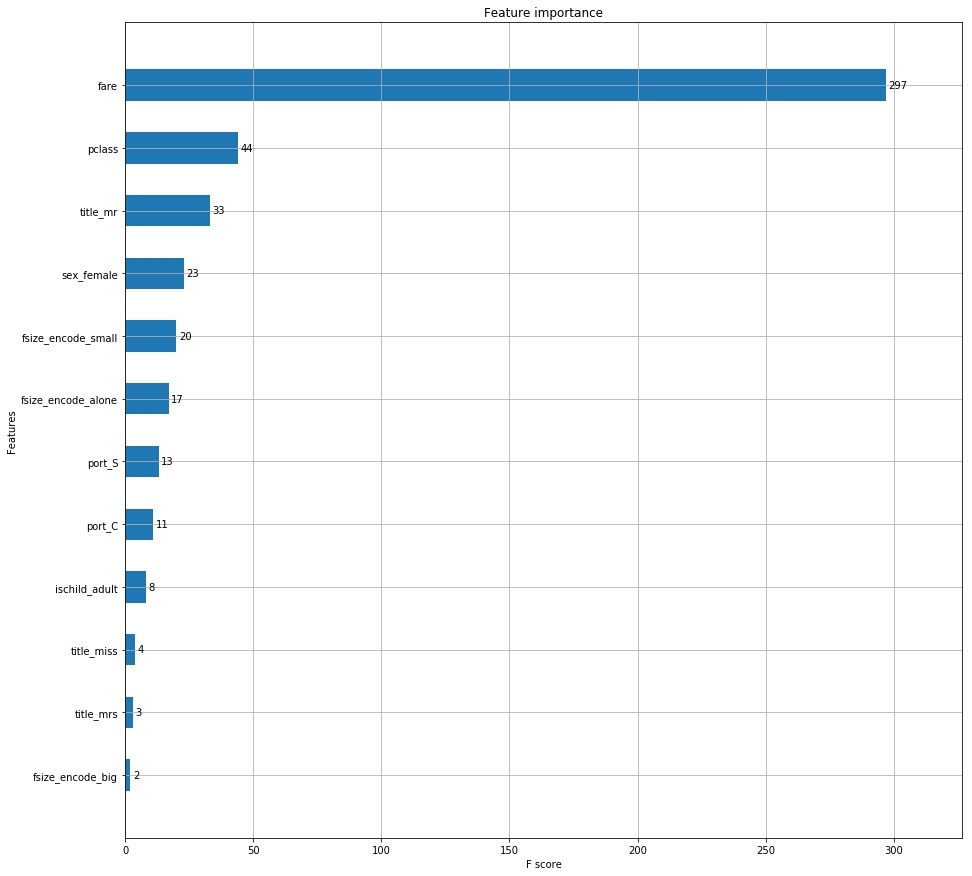

In [305]:
final_xgb = xgb_model(xgb_best)
xgb_pip = xgb_pipeline(final_xgb,xgb_features)
xgb_result = validate(xgb_pip,xgb_clf = final_xgb)

In [293]:
knn_features = DataFrameUnion([
    make_pipeline(ColumnSelector('pclass'),Scaling()),
    make_pipeline(FeatureTransformer(title),GetDummies()),
    make_pipeline(ColumnSelector('sex'),GetDummies()),
    make_pipeline(FeatureTransformer(fare),Scaling()),
    make_pipeline(FeatureTransformer(family_size),Scaling()),
#     make_pipeline(FeatureTransformer(fsize_encode),GetDummies()),
#     FeatureTransformer(magic_f),
#     make_pipeline(FeatureTransformer(ticket_counts),Scaling()),
#     make_pipeline(FeatureTransformer(imputed_age),Scaling()),
    make_pipeline(FeatureTransformer(ischild),GetDummies()),
    make_pipeline(FeatureTransformer(port),GetDummies()),
    
#     make_pipeline(FeatureTransformer(deck_encode),Scaling(),Fillna()),
#     make_pipeline(FeatureTransformer(cabin_no_encode),Scaling(),Fillna()),
])

In [278]:
pipeline_knn = Pipeline([
    ('features',knn_features),
#     ('pca',PCA(n_components = 13)),
    ('knn',KNeighborsClassifier())
])
param_grid = dict(
    knn__n_neighbors = [15,20,25],
    knn__weights = ['uniform','distance']
)
grid_search = GridSearchCV(pipeline_knn, param_grid=param_grid, verbose=10, scoring='roc_auc',cv=5)
grid_search.fit(X_train, y_train)
final_knn = grid_search.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] knn__n_neighbors=15, knn__weights=uniform .......................
[CV]  knn__n_neighbors=15, knn__weights=uniform, score=0.8567452955208057, total=   0.0s
[CV] knn__n_neighbors=15, knn__weights=uniform .......................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  knn__n_neighbors=15, knn__weights=uniform, score=0.8736573576799139, total=   0.0s
[CV] knn__n_neighbors=15, knn__weights=uniform .......................
[CV]  knn__n_neighbors=15, knn__weights=uniform, score=0.8249725877192982, total=   0.0s
[CV] knn__n_neighbors=15, knn__weights=uniform .......................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s


[CV]  knn__n_neighbors=15, knn__weights=uniform, score=0.8444353070175439, total=   0.0s
[CV] knn__n_neighbors=15, knn__weights=uniform .......................
[CV]  knn__n_neighbors=15, knn__weights=uniform, score=0.8952850877192982, total=   0.0s
[CV] knn__n_neighbors=15, knn__weights=distance ......................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s


[CV]  knn__n_neighbors=15, knn__weights=distance, score=0.8344818446859262, total=   0.0s
[CV] knn__n_neighbors=15, knn__weights=distance ......................
[CV]  knn__n_neighbors=15, knn__weights=distance, score=0.8376745435016112, total=   0.0s
[CV] knn__n_neighbors=15, knn__weights=distance ......................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.2s remaining:    0.0s


[CV]  knn__n_neighbors=15, knn__weights=distance, score=0.8410087719298246, total=   0.0s
[CV] knn__n_neighbors=15, knn__weights=distance ......................
[CV]  knn__n_neighbors=15, knn__weights=distance, score=0.7811129385964912, total=   0.0s
[CV] knn__n_neighbors=15, knn__weights=distance ......................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.3s remaining:    0.0s


[CV]  knn__n_neighbors=15, knn__weights=distance, score=0.8252467105263159, total=   0.0s
[CV] knn__n_neighbors=20, knn__weights=uniform .......................
[CV]  knn__n_neighbors=20, knn__weights=uniform, score=0.836734693877551, total=   0.0s
[CV] knn__n_neighbors=20, knn__weights=uniform .......................
[CV]  knn__n_neighbors=20, knn__weights=uniform, score=0.8623791621911924, total=   0.0s
[CV] knn__n_neighbors=20, knn__weights=uniform .......................
[CV]  knn__n_neighbors=20, knn__weights=uniform, score=0.834703947368421, total=   0.0s
[CV] knn__n_neighbors=20, knn__weights=uniform .......................
[CV]  knn__n_neighbors=20, knn__weights=uniform, score=0.8395010964912281, total=   0.0s
[CV] knn__n_neighbors=20, knn__weights=uniform .......................
[CV]  knn__n_neighbors=20, knn__weights=uniform, score=0.8884320175438596, total=   0.0s
[CV] knn__n_neighbors=20, knn__weights=distance ......................
[CV]  knn__n_neighbors=20, knn__weights=d

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    4.6s finished


In [279]:
print(final_knn)
print(grid_search.best_score_ ) 
knn_pip = Pipeline([
    ('features',knn_features),
#     ('pca',PCA(n_components = 13)),
    ('knn',final_knn)
])
knn_result = validate(pipeline_knn)

Pipeline(memory=None,
     steps=[('features', DataFrameUnion(trf_list=[Pipeline(memory=None,
     steps=[('columnselector', ColumnSelector(key='pclass')), ('scaling', Scaling())]), Pipeline(memory=None,
     steps=[('featuretransformer', FeatureTransformer(func=<function title at 0x00000165FA4BCF28>)), ('getdummies', GetDumm...wski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform'))])
0.8590353238686551
0.8579942645074224
             precision    recall  f1-score   support

          0       0.84      0.89      0.86       168
          1       0.79      0.72      0.75       100

avg / total       0.82      0.82      0.82       268

[[149  19]
 [ 28  72]]


In [280]:
logistic_features = DataFrameUnion([
    make_pipeline(ColumnSelector('pclass'),Scaling()),
    make_pipeline(FeatureTransformer(title),GetDummies()),
    make_pipeline(ColumnSelector('sex'),GetDummies()),
    FeatureTransformer(fare_encode),
#     FeatureTransformer(family_size),
    make_pipeline(FeatureTransformer(fsize_encode),GetDummies()),
    FeatureTransformer(magic_f),
#     make_pipeline(FeatureTransformer(ticket_counts),Scaling()),
#     make_pipeline(FeatureTransformer(imputed_age),Scaling()),
    make_pipeline(FeatureTransformer(ischild),GetDummies()),
    make_pipeline(FeatureTransformer(port),GetDummies()),
    
#     make_pipeline(FeatureTransformer(deck_encode),Scaling(),Fillna()),
#     make_pipeline(FeatureTransformer(cabin_no_encode),Scaling(),Fillna()),
])

In [281]:
clf_logistic = LogisticRegression(solver = 'liblinear')
pipeline_logistic = Pipeline([
    ('features',logistic_features),
#     ('pca',PCA(n_components = 13)),
#     ('drop',DropColumns('fsize_encode_alone')),
    ('logistic',clf_logistic)
])
logistic_result = validate(pipeline_logistic)

0.8664608636977059
             precision    recall  f1-score   support

          0       0.87      0.86      0.86       168
          1       0.76      0.78      0.77       100

avg / total       0.83      0.83      0.83       268

[[144  24]
 [ 22  78]]


In [282]:
def lgb_pipeline(clf,features):
    pip = Pipeline([
            ('features',features),
            ('lgb',clf)
         ])
    return pip

def lgb_model(argsDict):
    num_leaves = argsDict["num_leaves"]*10 + 2
    max_depth = argsDict["num_leaves"] + 2
    min_data_in_leaf = (argsDict["min_data_in_leaf"] + 5)*10
    bagging_fraction = argsDict["bagging_fraction"]
    bagging_freq = argsDict["bagging_freq"] + 2
    feature_fraction = argsDict["feature_fraction"]
    learning_rate = argsDict["learning_rate"]
    clf_lgb = lgb.LGBMClassifier(
        num_leaves = num_leaves,
        max_depth = max_depth,
        min_data_in_leaf = min_data_in_leaf,
        bagging_fraction = bagging_fraction,
        bagging_freq = bagging_freq,
        feature_fraction = feature_fraction,
        eval_metric = 'auc',
    )
    return clf_lgb

def obj_lgb(argsDict):
    clf_lgb = lgb_model(argsDict)
    pipeline = lgb_pipeline(clf_lgb,xgb_features)
    
    global X_train, y_train
    
#     print(clf_xgb)
    metric = cross_val_score(pipeline,X_train,y_train,cv=3,scoring="roc_auc").mean()
    print(metric)
    
    return -metric


In [284]:
lgb_space = {
    "num_leaves": hp.randint("num_leaves",10),
    'max_depth': hp.randint("max_depth",10),
    "min_data_in_leaf": hp.randint("min_data_in_leaf",10),
    "bagging_fraction": hp.uniform("bagging_fraction",0.2,0.8), 
    "bagging_freq": hp.randint("bagging_freq",15),
    "feature_fraction": hp.uniform("feature_fraction",0.2,0.8),
    "learning_rate": hp.uniform("learning_rate",0.005,0.2),  #[0,1,2,3,4,5] -> 0.05,0.06
}

lgb_best = fmin(obj_lgb,lgb_space,algo=tpe.suggest,max_evals=30)

print(lgb_best)

0.6064310537571692
0.820673341758206
0.8421768170182431
0.8190657302096497
0.5
0.6064310537571692
0.5
0.5
0.8344773743559832
0.6064310537571692
0.8555646689997083
0.5
0.8584761106250607
0.8506304478143935
0.6779041508700301
0.5
0.8563510579696056
0.5
0.8230586338744694
0.8509184326496225
0.8555709471501247
0.8456455963837852
0.8589651987945951
0.8581506594083147
0.8539969540844431
0.8545000162016785
0.8417665095103852
0.5
0.8365139253426656
0.8594684634328117
{'bagging_fraction': 0.6600084080120241, 'bagging_freq': 4, 'feature_fraction': 0.3134129029522275, 'learning_rate': 0.13200464587728147, 'max_depth': 9, 'min_data_in_leaf': 0, 'num_leaves': 1}


0.8604031713900134
             precision    recall  f1-score   support

          0       0.85      0.84      0.84       168
          1       0.74      0.75      0.74       100

avg / total       0.81      0.81      0.81       268

[[141  27]
 [ 25  75]]


C:\Users\Shang\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


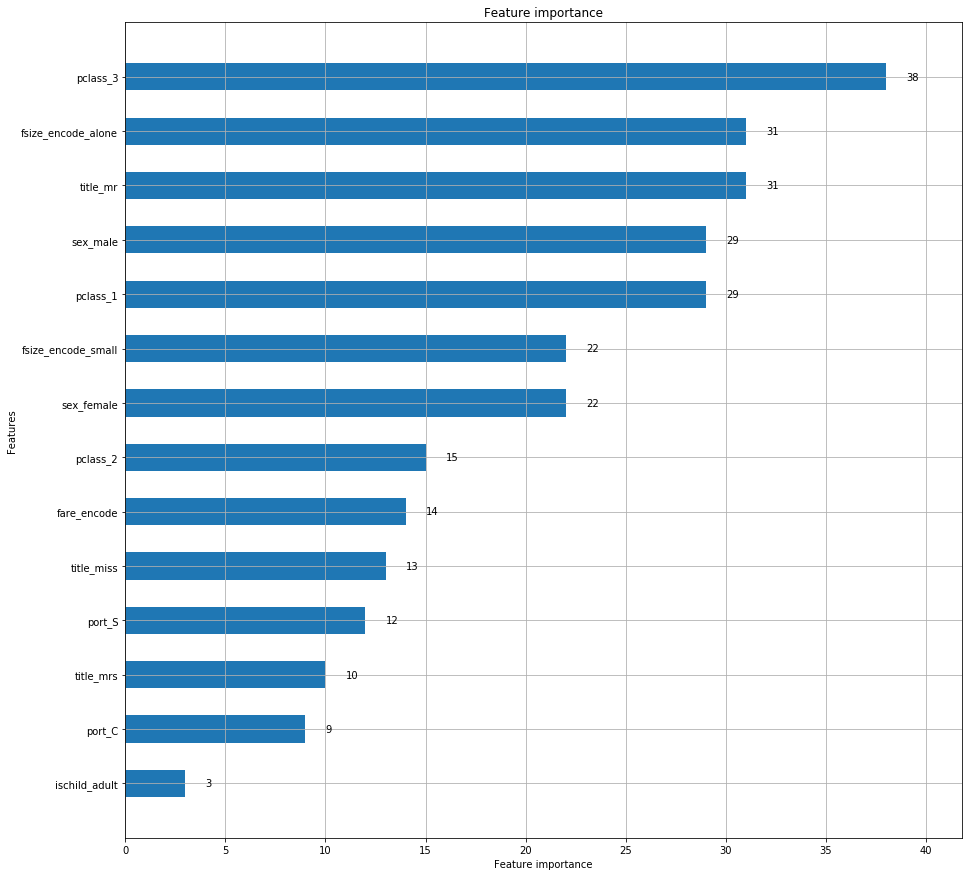

In [285]:
final_lgb = lgb_model(lgb_best)

lgb_pip = lgb_pipeline(final_lgb,xgb_features)
lgb_result = validate(lgb_pip, lgb_clf = final_lgb)

In [308]:
xgb_pip.fit(X,y)
submit1 = xgb_pip.predict(test)

rf_pip.fit(X,y)
submit2 = rf_pip.predict(test)

pipeline_logistic.fit(X,y)
submit3 = pipeline_logistic.predict(test)

submit4 = final_knn.predict(test)

lgb_pip.fit(X,y)
submit5 = lgb_pip.predict(test)

C:\Users\Shang\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Shang\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [309]:
submit = ((submit1 + submit2 + submit3 + submit4 )/4 > 0.5).astype(int)
survived = pd.DataFrame({'Survived':submit})
submit_csv = pd.concat([test.PassengerId,survived],axis=1)
#print(submit)
submit_csv.to_csv('submit.csv',index=False) 